In [1]:
from torchvision import transforms, datasets
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow
import os
from sklearn.metrics import accuracy_score

In [2]:
softmax = nn.Softmax(dim=-1)
def run_epoch(model, loss_func, data_loader, device, optimizer=None, score_funcs=None):
    running_loss = 0.0
    if score_funcs is not None:
        score = dict()
        for i in score_funcs.keys():
            score[str(i)] = []
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_hat = model(inputs)
        loss = loss_func(y_hat, labels)
        if model.training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if score_funcs is not None:
            y_hat_soft = softmax(y_hat.cpu())
            y_pred = [np.argmax(y_hat_soft[i,:]) for i in range(len(labels))]
            for i in score_funcs.keys():
                score[str(i)].append(score_funcs[i](labels.tolist(), y_pred))
        running_loss += loss.item()
    if score_funcs is not None:
        for i in score_funcs.keys():
            print(i+":",sum(score[i])/len(score[i]))
    return running_loss

In [3]:
def train_network(model, loss_func, training_loader, optimizer, lr_schedule, 
    score_funcs=None, testing_loader=None, val_loader=None, epochs=20, device="cpu",\
    checkpoint_file=None):
    model.to(device)
    losses_train = []
    losses_test = []
    for epoch in tqdm(range(epochs), desc="Epoch", position=0):
        model = model.train()
        losses_train.append(run_epoch(model, loss_func, training_loader, device, \
            optimizer=optimizer))
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau) \
                and val_loader is not None:
                model.eval()
                with torch.no_grad():
                    eval_loss = run_epoch(model, loss_func, val_loader, device)
                lr_schedule.step(eval_loss)
            else:
                lr_schedule.step()
    if score_funcs is not None and testing_loader is not None:
        model = model.eval()
        with torch.no_grad():
            losses_test.append(run_epoch(model, loss_func, testing_loader, device, score_funcs=score_funcs))
    if checkpoint_file is not None:
        torch.save({'model_state_dict':model.state_dict(), \
            'optimizer_state_dict': optimizer.state_dict()}, checkpoint_file)
    return losses_train, losses_test

In [17]:
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=45, fill=(255, 255, 255)),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), fill=(255, 255, 255)),
    transforms.RandomAffine(degrees=0, shear=10, fill=(255,255,255)),
    transforms.ToTensor()])
    
img_basic_transform = transforms.Compose([transforms.Resize((224, 224)),
    transforms.ToTensor()])
    
train_img_path = "./train/"
train_dataset_n = datasets.ImageFolder(train_img_path, transform=img_basic_transform)
train_dataset_t = datasets.ImageFolder(train_img_path, transform=img_transforms)
train_dataset = torch.utils.data.ConcatDataset([train_dataset_n, train_dataset_t])
test_img_path = "./test/"
test_dataset = datasets.ImageFolder(test_img_path, transform=img_basic_transform)

In [5]:
class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        pad = (kernel_size-1)//2
        self.F = nn.Sequential(nn.Conv2d(channels, channels, kernel_size, 
            padding=pad),nn.BatchNorm2d(channels), nn.LeakyReLU(leak_rate),
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),nn.LeakyReLU(leak_rate))
    def forward(self, x):
        return x + self.F(x)

In [6]:
class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        pad = (kernel_size-1)//2
        bottleneck = out_channels//4 #tune this later
        self.F = nn.Sequential(nn.BatchNorm2d(in_channels), nn.LeakyReLU(leak_rate),
            nn.Conv2d(in_channels, bottleneck, 1, padding=0),
            nn.BatchNorm2d(bottleneck),nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            nn.BatchNorm2d(bottleneck),nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, out_channels, 1, padding=0))
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, padding=0), \
                nn.BatchNorm2d(out_channels))
    def forward(self, x):
        return self.shortcut(x) + self.F(x)
    

# Data Analysis

Visualize some data

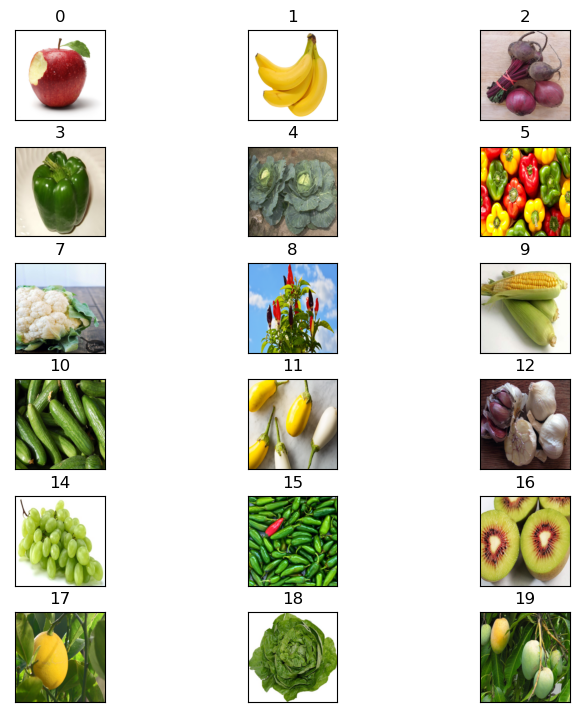

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(8, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    x_example, y_example = train_dataset[i*100]
    ax.imshow(x_example.permute(1, 2, 0))
    ax.set_title(y_example, fontsize = 12)
plt.tight_layout(pad=0.1)
plt.show()


Observe the class distribution

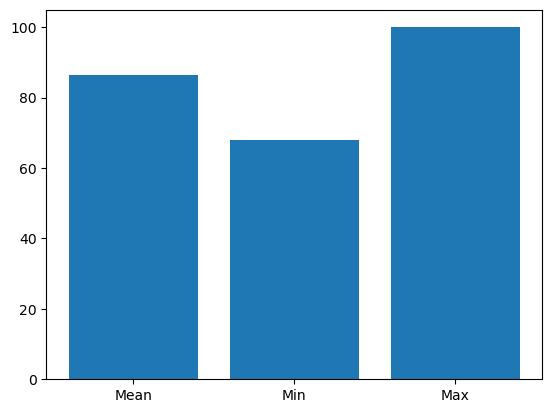

In [8]:
from collections import Counter
t = train_dataset_n.targets
label_counts = Counter(t).values()
classes = train_dataset_n.classes
plt.bar(["Mean", "Min", "Max"], [np.mean(list(label_counts)), min(label_counts), max(label_counts)])
plt.show()

# Training

In [12]:
device = torch.device("cuda")
B = 32
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=B)
D = 224*224 #28px * 28px
C = 3 #rgb
classes = len(os.listdir("./train")) #36
kernel_size = 3
n_filters = 15
leak_rate = 0.15

In [13]:
cnn_res_model = nn.Sequential(ResidualBottleNeck(C, n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), nn.MaxPool2d((2,2)), ResidualBlockE(n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), ResidualBottleNeck(n_filters, 2*n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), nn.MaxPool2d((2,2)), ResidualBlockE(2*n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), ResidualBottleNeck(2*n_filters, 4*n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), ResidualBlockE(4*n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), nn.Flatten(), nn.Linear(D*n_filters//4, classes))

loss_func = nn.CrossEntropyLoss()
score_funcs={'Acc':accuracy_score}
T = 6
optimizer = torch.optim.SGD(cnn_res_model.parameters(), lr=0.0003, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,  T//2 ,eta_min=0.0001)
losses = train_network(cnn_res_model, loss_func, train_loader, optimizer, 
    scheduler, score_funcs, test_loader, epochs=T, device="cuda")

# Evaluation

In [14]:
checkpoint_dict = torch.load('best_acc.pt', map_location="cuda")
cnn_res_model.load_state_dict(checkpoint_dict['model_state_dict'])

<All keys matched successfully>

In [15]:
val_img_path = "./validation/"
val_dataset = datasets.ImageFolder(val_img_path, transform=img_crop_transform)
true_labels = []
predicted_labels = []
misclassified = []
features = []
label_ids = []
with torch.no_grad():
    cnn_res_model.to(device)
    cnn_res_model.eval()
    for image, label in val_dataset:
        logits = cnn_res_model(image.unsqueeze(0).to(device))
        features.append(logits.squeeze().detach().cpu().numpy())
        y_hat = softmax(logits.cpu())
        predicted_labels.append(val_dataset.classes[int(np.argmax(y_hat))])
        true_labels.append(val_dataset.classes[label])
        label_ids.append(int(np.argmax(y_hat)))
        if test_dataset.classes[int(np.argmax(y_hat))] != val_dataset.classes[label]:
             misclassified.append([image, test_dataset.classes[int(np.argmax(y_hat))], \
                val_dataset.classes[label], y_hat.max()]) #stores img, y_true, y_pred, and prob                                    

In [18]:
val_img_path = "./validation/"
val_dataset = datasets.ImageFolder(val_img_path, transform=img_basic_transform)
true_labels = []
predicted_labels = []
misclassified = []
features = []
label_ids = []
with torch.no_grad():
    cnn_res_model.to(device)
    cnn_res_model.eval()
    for image, label in val_dataset:
        logits = cnn_res_model(image.unsqueeze(0).to(device))
        features.append(logits.squeeze().detach().cpu().numpy())
        y_hat = softmax(logits.cpu())
        predicted_labels.append(val_dataset.classes[int(np.argmax(y_hat))])
        true_labels.append(val_dataset.classes[label])
        label_ids.append(int(np.argmax(y_hat)))
        if test_dataset.classes[int(np.argmax(y_hat))] != val_dataset.classes[label]:
             misclassified.append([image, test_dataset.classes[int(np.argmax(y_hat))], \
                val_dataset.classes[label], y_hat.max()]) #stores img, y_true, y_pred, and prob  

6.267806267806268% are misclassified


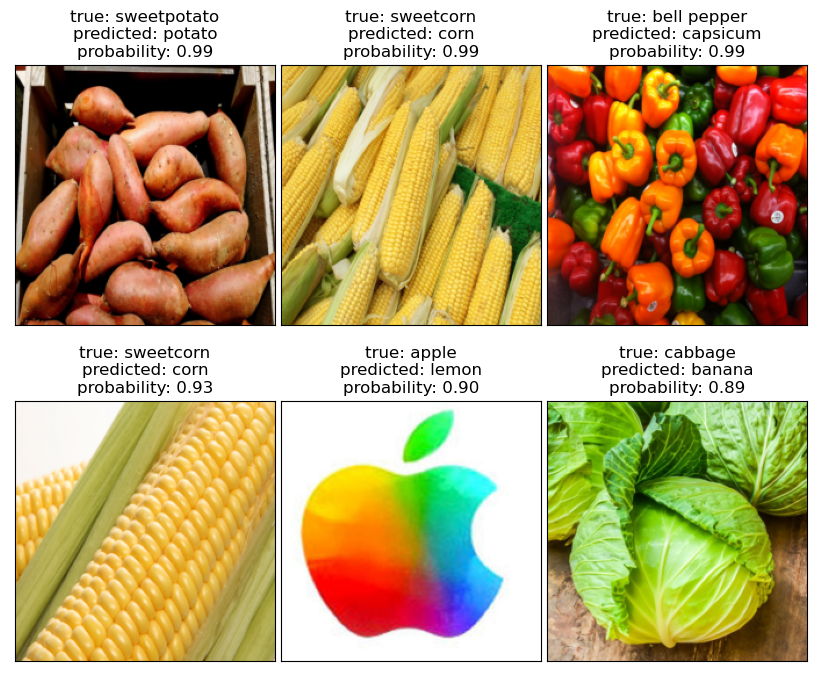

In [19]:
def Sort(pred):
    pred.sort(key = lambda x: x[3]) #sort using prob
    return pred 
print(str(len(misclassified)/len(val_dataset)*100)+"% are misclassified")
sorted_pred = Sort(misclassified) #creates sorted list of descending probabilities
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    x_example, y_pred, y_example, prob = sorted_pred[-(i+1)]
    ax.imshow(x_example.permute(1, 2, 0))
    ax.set_title("true: "+y_example+"\npredicted: "+y_pred+"\nprobability: "+str(prob.item())[:4], fontsize = 12)
plt.tight_layout(pad=0.1)
plt.show()

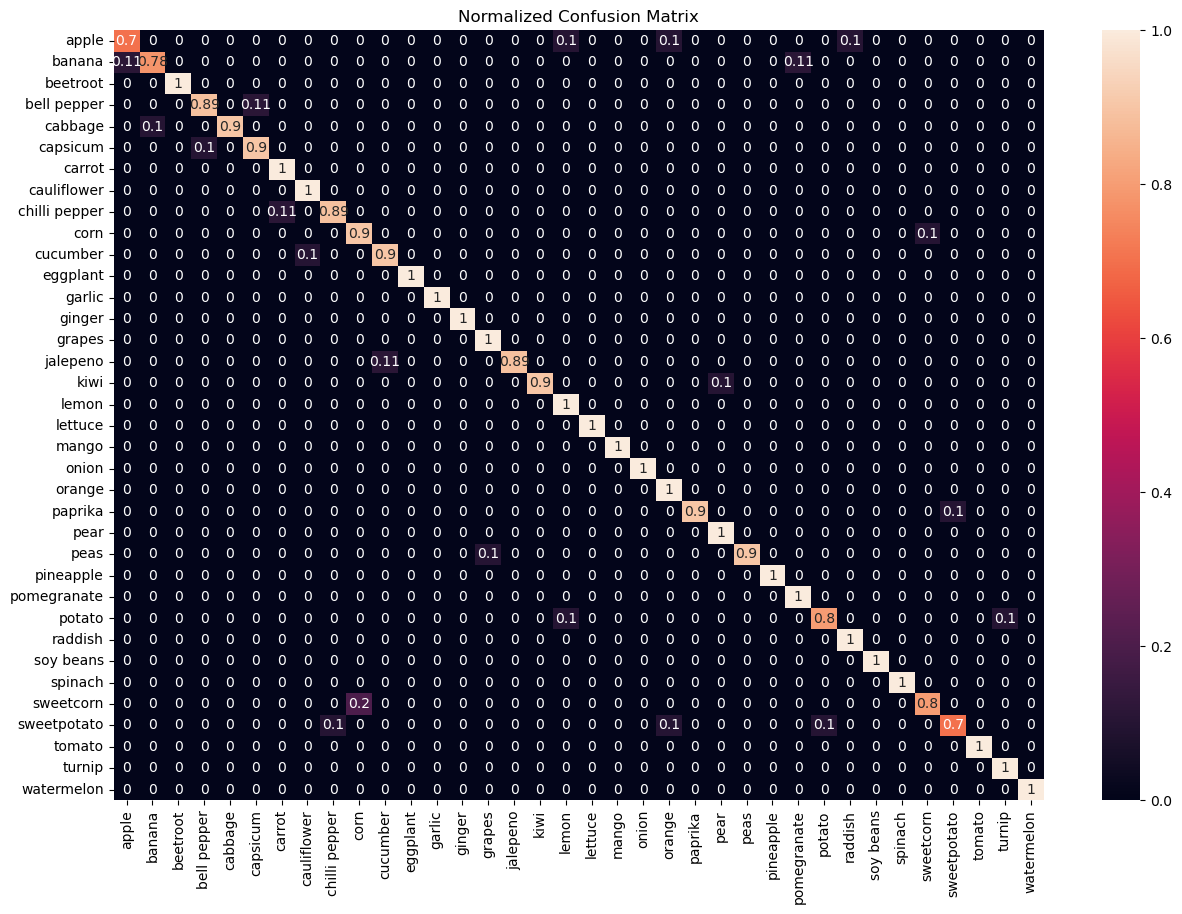

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(true_labels)), 
            yticklabels = sorted(set(true_labels)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

In [22]:
def predict(path):
    image = plt.imread(path)
    transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224)), transforms.ToTensor()])
    pil_img = (transform(image))
    with torch.no_grad():
        cnn_res_model.to(device)
        cnn_res_model.eval()
        logits = cnn_res_model(pil_img.unsqueeze(0).to(device))
        logits.squeeze().detach().cpu().numpy()
        y_hat = softmax(logits.cpu())
    plt.title("predicted: "+test_dataset.classes[int(np.argmax(y_hat))])
    plt.imshow(pil_img.permute(1, 2, 0))

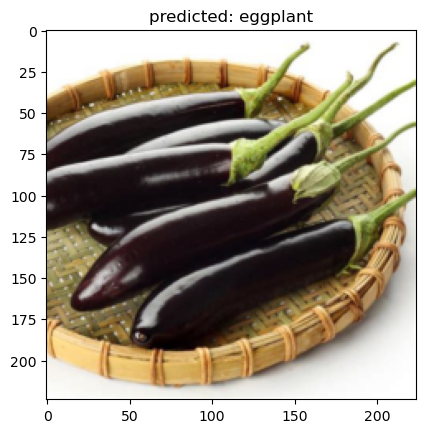

In [79]:
predict("14.jpg") 